In [1]:
import os
import sys
sys.path.append('../../')

import pandas as pd
import xgboost as xgb
import numpy as np
import swifter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta
from tqdm import tqdm, tqdm_notebook
from category_encoders import TargetEncoder
import core.config as conf

In [2]:
tqdm_notebook().pandas()

<ipython-input-2-cb18d13d338b>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


## 01. Train Data Load

In [3]:
## load preprocessing data (past_d)
# train_df = pd.read_csv('./result/train_past_d.csv')
# test_df = pd.read_csv('./result/test_past_d.csv')

In [4]:
path = conf.data_path

In [5]:
# train_df = pd.read_csv(f'{path}'+'stk_hld_train.csv')
train_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'stk_hld_train.csv') # 아정

In [6]:
train_df.head()

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324


In [7]:
# cus_df = pd.read_csv(f'{path}'+'cus_info.csv')
cus_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'cus_info.csv') # 아정

In [8]:
cus_df.head()

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [9]:
# iem_df = pd.read_csv(f'{path}'+'iem_info_20210902.csv')
iem_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'iem_info_20210902.csv')  # 아정

In [10]:
iem_df.head()

,iem_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


### 종목 Label Encoding

In [11]:
L_encoder = LabelEncoder()
L_encoder.fit(iem_df["iem_krl_nm"])

LabelEncoder()

In [12]:
iem_df['iem_krl_nm'] = L_encoder.transform(iem_df["iem_krl_nm"])

In [13]:
train_df = pd.merge(left = train_df, right = cus_df, how='left', on='act_id')

In [14]:
train_df = pd.merge(train_df, iem_df, how='left', on='iem_cd')

## 02. Test Data Load

In [15]:
# test_df = pd.read_csv(f'{path}'+'stk_hld_test.csv')
test_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'stk_hld_test.csv')  # 아정

In [16]:
test_df = pd.merge(left = test_df, right = cus_df, how='left', on='act_id')

In [17]:
test_df = pd.merge(test_df, iem_df, how='left', on='iem_cd')

In [18]:
test_df.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,2,9,5,5,8,418,4,1,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,2,9,5,5,8,2230,10,3,99
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,2,9,5,5,8,1515,13,2,99
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,2,9,5,5,8,2681,13,3,99
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,2,9,5,5,8,2450,13,1,2


## 03. Stock Hist

In [19]:
# stk_df = pd.read_csv(f'{path}'+'stk_bnc_hist.csv')
stk_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'stk_bnc_hist.csv')  # 아정

In [20]:
stk_df.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


## 04. Data Preprocessing

### hist d : 

In [21]:
train_df["hist_d"] = train_df["hold_d"]*0.6

In [22]:
def working_day(s_dt, e_dt) : # 공휴일 제외
    s_dt = str(s_dt).split('.')[0]
    e_dt = str(e_dt).split('.')[0]
    s_dt = s_dt[:4] + '-' + s_dt[4:6] + '-' + s_dt[6:]
    e_dt = e_dt[:4] + '-' + e_dt[4:6] + '-' + e_dt[6:]
    return np.busday_count(s_dt, e_dt, weekmask='1111100')

### External Data Featuring
- 종목 별 volume feature 추가

In [23]:
external_path = conf.external_path
print(external_path)

~/2021-nh-bigdata-competition/external/result/


In [24]:
# stk_mean_df = pd.read_csv(external_path+'mean_stockdata.csv')
stk_mean_df = pd.read_csv('~/Study/' + external_path[2:] +'mean_stockdata.csv') # 아정

In [25]:
stk_mean_df['code'] = stk_mean_df.apply(lambda x : 'A' + x['code'], axis = 1)

In [26]:
stk_mean_df

,code,open,high,low,close,volume,change
0,A000020,10628.321108,10875.158924,10395.338223,10611.340668,4.514417e+05,0.001178
1,A000030,13718.842105,13873.710526,13566.907895,14156.565789,1.592198e+06,0.000800
2,A000040,3205.013040,3268.528117,3137.779136,3229.211084,1.243295e+06,-0.000945
3,A000050,13186.233089,13408.596577,12970.257539,13402.982885,3.864996e+04,-0.000098
4,A000060,18285.819071,18510.423798,18045.867971,18283.928280,1.757751e+05,0.000082
...,...,...,...,...,...,...,...
2807,A371470,10585.937500,10747.812500,10474.375000,10595.937500,2.414732e+05,0.007861
2808,A371870,10113.500000,10179.500000,9927.500000,10037.000000,1.963900e+04,0.000063
2809,A372330,10127.000000,10232.000000,9951.000000,10080.000000,8.949426e+05,0.001339
2810,A373490,10156.500000,10307.250000,10123.000000,10264.500000,9.705650e+04,0.016875


In [27]:
train_df = pd.merge(left = train_df, right = stk_mean_df[['code', 'volume']], how='left', left_on='iem_cd', right_on = 'code')

In [28]:
test_df = pd.merge(left = test_df, right = stk_mean_df[['code', 'volume']], how='left', left_on='iem_cd', right_on = 'code')

### Target Encoding
종목 별 hold_d를 사용해서 종목 코드를 target encoding

In [29]:
target_encoder = TargetEncoder()

In [30]:
target_encoder.fit(train_df['iem_cd'], train_df['hold_d'])

TargetEncoder(cols=['iem_cd'])

In [31]:
train_df['iem_cd_te'] = target_encoder.transform(train_df['iem_cd'], train_df['hold_d'])

In [32]:
test_df['iem_cd_te'] = target_encoder.transform(test_df['iem_cd'], test_df['hold_d'])

In [33]:
test_df = test_df.fillna(0)

In [34]:
train_df = train_df.fillna(0)

In [35]:
#target_encoder.transform(train_df['ivs_icn_cd'], train_df['hold_d'])

### past_d 계산
user 별 종목 past_d

In [36]:
# id_stk_dur_df = pd.read_csv(conf.data_path + 'id_stk_dur_list.csv')
id_stk_dur_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'id_stk_dur_list.csv') # 아정

In [37]:
train_df = pd.merge(train_df, id_stk_dur_df[['act_id', 'iem_cd', 'act_past_d_mean']], how = 'left', on = ['act_id', 'iem_cd'])
train_df

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,...,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,hist_d,code,volume,iem_cd_te,act_past_d_mean
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,1,9,3,2,2,9,...,8,101,1,1,1,6.6,A006360,5.609763e+05,23.934985,6.5
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,1,9,3,2,2,9,...,8,1361,9,1,1,48.0,A005930,8.282941e+06,35.437256,86.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,1,9,3,2,2,9,...,8,2530,12,2,99,3.0,A005070,6.215593e+05,20.464120,6.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,1,9,3,2,2,9,...,8,1969,8,2,1,13.2,A003520,4.134687e+06,19.122137,22.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,1,9,3,2,2,9,...,8,1696,10,3,99,194.4,A002310,4.212912e+04,27.660819,347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,1,4,4,2,2,3,...,8,1752,10,3,99,0.6,A260660,6.174929e+05,14.380000,1.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,1,4,4,2,2,3,...,8,2344,8,2,99,0.6,A271980,2.948565e+05,14.700000,1.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,1,4,4,2,2,3,...,8,521,2,2,99,0.6,A289080,6.089245e+06,11.607744,1.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,1,4,4,2,2,3,...,8,2460,2,3,99,0.6,A307930,9.100245e+05,16.943609,1.0


In [38]:
test_df = pd.merge(test_df, id_stk_dur_df[['act_id', 'iem_cd', 'act_past_d_mean']], how = 'left', on = ['act_id', 'iem_cd'])

### 투자성향 별 past_d 계산

In [39]:
# ivs_past_df = pd.read_csv(conf.data_path + 'preprocessing/ivs_past_d_mean.csv')
ivs_past_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'preprocessing/ivs_past_d_mean.csv')  # 아정

In [40]:
train_df = pd.merge(train_df, ivs_past_df, how = 'left', on = ['iem_cd', 'ivs_icn_cd'])

In [41]:
test_df = pd.merge(test_df, ivs_past_df, how = 'left', on = ['iem_cd', 'ivs_icn_cd'])

In [42]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

### Drop Features

In [43]:
train_df = train_df.drop(['act_id', 'iem_cd', 'code', 'byn_dt'], axis = 1)

In [44]:
used_features = train_df.columns.drop('hold_d')

In [45]:
test_df = test_df[used_features]

In [46]:
train_df.columns

Index(['hold_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'iem_cd_te',
       'act_past_d_mean', 'ivs_past_d_mean'],
      dtype='object')

In [47]:
test_df.columns

Index(['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
       'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'iem_cd_te',
       'act_past_d_mean', 'ivs_past_d_mean'],
      dtype='object')

In [48]:
train_df

,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,hist_d,volume,iem_cd_te,act_past_d_mean,ivs_past_d_mean
0,11,1,9,3,2,2,9,5,5,8,101,1,1,1,6.6,5.609763e+05,23.934985,6.5,39.551724
1,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,48.0,8.282941e+06,35.437256,86.0,55.771863
2,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,3.0,6.215593e+05,20.464120,6.0,25.934524
3,22,1,9,3,2,2,9,5,5,8,1969,8,2,1,13.2,4.134687e+06,19.122137,22.0,24.164948
4,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,194.4,4.212912e+04,27.660819,347.0,42.586207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,1,1,4,4,2,2,3,4,3,8,1752,10,3,99,0.6,6.174929e+05,14.380000,1.0,17.975904
681468,1,1,4,4,2,2,3,4,3,8,2344,8,2,99,0.6,2.948565e+05,14.700000,1.0,15.159763
681469,1,1,4,4,2,2,3,4,3,8,521,2,2,99,0.6,6.089245e+06,11.607744,1.0,15.371429
681470,1,1,4,4,2,2,3,4,3,8,2460,2,3,99,0.6,9.100245e+05,16.943609,1.0,24.973684


### Data Scaling

Train/Test 데이터에 대해 정규화 수행
sklearn의 정규화 함수 이용
- StandardScalar
- MinMaxScalar
- MaxAbsScalar
- RobustScalar

In [49]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [50]:
# 피처 각각에 대한 scaling을 수행합니다.
# scale_columns = ['hold_d', 'hist_d', 'volume', 'iem_cd_te', 'act_past_d_mean','ivs_past_d_mean']
scale_columns = ['hist_d', 'volume', 'iem_cd_te', 'act_past_d_mean','ivs_past_d_mean']
df = standard_scaling(train_df, scale_columns)

In [67]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['hist_d', 'volume', 'iem_cd_te', 'act_past_d_mean','ivs_past_d_mean']
df = standard_scaling(test_df, scale_columns)

## 05. XGBoost
model : 기본 XGBoost 모델  
xgb_grid : GridSearch libarary를 통해서 model 최적 파라미터 구한 모델  
* 둘 중 하나로 테스트해보면 되는데 xgb_grid는 정확도가 올라가는 대신 시간 매우 오래 걸림

In [51]:
train_df

,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,hist_d,volume,iem_cd_te,act_past_d_mean,ivs_past_d_mean
0,11,1,9,3,2,2,9,5,5,8,101,1,1,1,-0.163197,-0.288372,0.515073,-0.295958,0.520452
1,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,1.147304,1.593348,1.871933,1.254545,1.327972
2,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,-0.277154,-0.273609,0.105634,-0.305710,-0.157480
3,22,1,9,3,2,2,9,5,5,8,1969,8,2,1,0.045723,0.582485,-0.052673,0.006341,-0.245578
4,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,5.781538,-0.414807,0.954589,6.344876,0.671524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,1,1,4,4,2,2,3,4,3,8,1752,10,3,99,-0.353125,-0.274600,-0.612077,-0.403226,-0.553700
681468,1,1,4,4,2,2,3,4,3,8,2344,8,2,99,-0.353125,-0.353221,-0.574328,-0.403226,-0.693901
681469,1,1,4,4,2,2,3,4,3,8,521,2,2,99,-0.353125,1.058779,-0.939105,-0.403226,-0.683364
681470,1,1,4,4,2,2,3,4,3,8,2460,2,3,99,-0.353125,-0.203314,-0.309662,-0.403226,-0.205315


In [52]:
col = train_df.columns

In [53]:
col = col.drop('hold_d')

In [54]:
TARGET = 'hold_d'

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[col], train_df[TARGET], test_size = 0.2)

In [56]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=8, min_child_weighteta=0.1, subsample=0.7, colsample_bytree=0.8)

#### GridSearch

In [57]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'eta' :[0.05, 0.1],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [1, 2, 4, 6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [58]:
model.fit(X_train, y_train, verbose=False)

[12:42:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_child_weighteta } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_child_weighteta=0.1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [65]:
xgb_grid.fit(X_train, y_train, verbose=False)

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[13:56:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:29] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:29] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.

[13:56:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:58:02] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:02] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:58:35] WARNING: ../src/objective/regression_obj.cu:171: 

[13:56:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:29] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:29] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:58:34] WARNING: ../src/objective/regression_obj.cu:171: 

[13:56:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:58:04] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:58:04] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:59:09] WARNING: ../src/objective/regression_obj.cu:171: 

[13:56:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:30] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:30] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:58:37] WARNING: ../src/objective/regression_obj.cu:171: 


[14:15:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:10] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:15:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:52] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:16:34] WARNING: ../src/objective/regression_obj.cu:171:

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



[14:17:03] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:03] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:52] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:19:28] WARNING: ../src/objective/regression_obj.cu:171:

[14:23:08] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:08] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:56] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:25:31] WARNING: ../src/objective/regression_obj.cu:171: 

[14:22:55] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:56] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:23:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:51] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:46] WARNING: ../src/objective/regression_obj.cu:171: 

[14:24:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:24] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:26:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:10] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:20] WARNING: ../src/objective/regression_obj.cu:171: 

[14:23:35] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:35] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:29] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:29] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:26:15] WARNING: ../src/objective/regression_obj.cu:171: 


[14:35:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:42] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:36:36] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:36] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:38:30] WARNING: ../src/objective/regression_obj.cu:171:


[14:41:08] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:08] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:42:16] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:42:16] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:42] WARNING: ../src/objective/regression_obj.cu:171:


[14:42:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:42:40] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:22] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:22] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:44:45] WARNING: ../src/objective/regression_obj.cu:171:


[14:42:44] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:42:44] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:26] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:26] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:44:06] WARNING: ../src/objective/regression_obj.cu:171:

[14:51:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:33] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:53:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:20] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:53:55] WARNING: ../src/objective/regression_obj.cu:171: 

[14:51:14] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:14] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:52:12] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:12] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:53:08] WARNING: ../src/objective/regression_obj.cu:171: 


[15:00:30] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:30] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:02:08] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:08] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:02:55] WARNING: ../src/objective/regression_obj.cu:171:

[15:22:38] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:22:38] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=8, min_child_weight=1,
                                    min_child_weighteta=0.1, missing=nan,
                                    monotone_constraints='()',
                                    n_estimators=...
                                    scale_pos_weight=1, subsample=0.7,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.05,


[15:02:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:56] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:53] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:53] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:05:45] WARNING: ../src/objective/regression_obj.cu:171:


[15:04:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:10] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:05:06] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:06] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:07:00] WARNING: ../src/objective/regression_obj.cu:171:

In [59]:
import joblib

In [65]:
joblib.dump(xgb_grid, 'xgb_gridcv.pkl')

['xgb_gridcv.pkl']

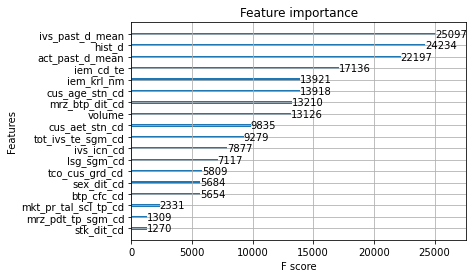

In [60]:
xgb.plot_importance(model)

In [67]:
xgb_grid.score(X_train, y_train)   

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [61]:
model.score(X_train, y_train)

0.9999811210739691

## Predict Score

In [62]:
pred = model.predict(X_valid)

In [175]:
pred = xgb_grid.predict(X_valid)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [63]:
y_valid.values

array([ 1,  1,  9, ..., 24,  5,  6])

In [64]:
np.round(pred)

array([ 1.,  1., 10., ..., 24.,  5.,  6.], dtype=float32)

In [65]:
np.sqrt(mean_squared_error(y_valid.values, np.round(pred)))

1.3892645997977562

## 04. Submission

In [66]:
# submission = pd.read_csv(f"{path}"+"sample_submission.csv")
submission = pd.read_csv('~/Study/' + conf.data_path[2:] +"sample_submission.csv")

In [74]:
y_pred = xgb_grid.predict(test_df) 

In [68]:
y_pred = model.predict(test_df)

In [69]:
y_pred

array([ 32.142685  ,  90.395905  ,  27.992163  , ..., 240.11702   ,
         0.99234277,   0.8504942 ], dtype=float32)

In [70]:
result = []
for i in y_pred:
    result.append(i)

In [71]:
result

[32.142685,
 90.395905,
 27.992163,
 59.885803,
 0.73724836,
 13.663478,
 15.949343,
 216.73703,
 9.410539,
 136.79047,
 23.299776,
 396.55096,
 129.29411,
 1.1357872,
 1.8457408,
 1.0217003,
 18.619587,
 5.281081,
 74.53543,
 1.0547683,
 0.62090075,
 378.14435,
 117.97628,
 1.3559144,
 0.86596394,
 4.9410625,
 5.897606,
 59.600266,
 134.14713,
 73.54723,
 5.3305464,
 4.5757422,
 261.34216,
 24.939194,
 1.4646723,
 8.24114,
 24.514153,
 384.93665,
 25.40533,
 338.78506,
 363.15106,
 125.88867,
 320.67352,
 362.2997,
 355.0998,
 168.82643,
 322.1561,
 386.68314,
 391.09174,
 384.97977,
 374.67694,
 320.99628,
 27.869473,
 190.97173,
 199.59767,
 29.639599,
 23.834114,
 187.19334,
 187.51945,
 214.7311,
 6.8251953,
 200.25528,
 196.20396,
 222.2639,
 169.1819,
 222.84116,
 197.75287,
 7.6928344,
 21.486958,
 194.71434,
 216.60417,
 224.62181,
 199.17477,
 371.61136,
 0.72803175,
 30.65249,
 1.0044757,
 0.97435844,
 30.763596,
 0.880679,
 0.96027786,
 314.89557,
 381.5391,
 271.65717,
 1.

In [72]:
submission["hold_d"] = np.round(result)

In [73]:
submission

,submit_id,hold_d
0,IDX00001,32.0
1,IDX00002,90.0
2,IDX00003,28.0
3,IDX00004,60.0
4,IDX00005,1.0
...,...,...
70591,IDX70592,1.0
70592,IDX70593,16.0
70593,IDX70594,240.0
70594,IDX70595,1.0


In [74]:
submission.to_csv("./result/xgboost(iem_cd_target_encoding lib with hist_d volume past_d(mean) ivs past_d & scaling).csv", index = False)

In [76]:
train_df.columns

Index(['hold_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'iem_cd_te',
       'act_past_d_mean', 'ivs_past_d_mean'],
      dtype='object')

In [77]:
test_df.columns

Index(['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
       'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'iem_cd_te',
       'act_past_d_mean', 'ivs_past_d_mean'],
      dtype='object')

In [78]:
test_df

,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,hist_d,volume,iem_cd_te,act_past_d_mean,ivs_past_d_mean
0,1,9,3,2,2,9,5,5,8,418,4,1,1,0.244175,0.039721,0.073982,0.298371,0.083664
1,1,9,3,2,2,9,5,5,8,2230,10,3,99,1.361902,-0.341544,0.148961,1.490101,0.084534
2,1,9,3,2,2,9,5,5,8,1515,13,2,99,0.158196,-0.376782,0.114638,0.212811,-0.107178
3,1,9,3,2,2,9,5,5,8,2681,13,3,99,0.753908,-0.238048,-0.401725,0.842289,-0.005340
4,1,9,3,2,2,9,5,5,8,2450,13,1,2,-0.640180,-0.045461,-0.805707,-0.612233,-0.266645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,1,6,0,5,2,5,3,5,2,1369,2,1,1,-0.554201,-0.393597,0.140479,-0.596954,-0.703553
70592,1,6,0,5,2,5,3,5,2,444,2,99,99,-0.062893,-0.399973,2.143246,-0.007201,2.076436
70593,1,4,4,2,2,3,4,3,8,1280,14,3,99,4.573831,-0.206895,-1.394850,4.900282,9.795720
70594,1,4,4,2,2,3,4,3,8,2373,8,2,99,-0.627897,-0.408747,0.139291,-0.633623,-0.200188
